## Week 2 Assignment
This Jupyter Notebook is submitted as part of the Applied Data Science Capstone Course (IBM & Coursera).

## 2. Data Understanding
### 2.1 Understanding the Dataset
The purpose of this chapter is to gain a preliminary understanding of the Collision Dataset for the reason of selecting the label variable and potential features to predict it. In the next chapter, the selected label and feature variables will undergo pre-processing, which includes all measures of transforming and cleaning the data so that it can be read by the machine learning algorithm. 

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.style.use(['ggplot'])

In [ ]:
# download the dataset
!wget -O DataCollision.csv https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv

In [2]:
# read the dataset into dataframe 
df = pd.read_csv('DataCollision.csv')
print(df.shape)
df.head(2)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(194673, 38)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N


As stated before, this report uses the Collision Dataset from the city of Seattle.  The given dataset has 194,673 rows of observations, i.e. reported collisions, and 38 columns, which correspond to various attributes about and around the collisions. The dependent variable, also known as label, is the class that the classification algorithm should predict. In the Collision Dataset, the label is `SEVERITYCODE` , which can take two values: 
- 1 = property damage only,
- 2 = injury collision.

Of those collisions, 136,485 belong to class 1, property damage, and 58,188 belong to class 2, injury collision. An imbalance in the labels is natural in with real-world phenomena but will bias the machine learning algorithm. The issue of imbalance will be addressed in the next chapter. The information about the label can be taken either from the metadata or from the column `SEVERITYDESC`.  Thus, `SEVERITYCODE.1` being a duplicate of `SEVERITYCODE` can be dropped along with `SEVERITYDESC` and `COLLISIONTYPE`.

In [3]:
df.groupby(['SEVERITYDESC'])['SEVERITYCODE'].value_counts()

SEVERITYDESC                    SEVERITYCODE
Injury Collision                2                58188
Property Damage Only Collision  1               136485
Name: SEVERITYCODE, dtype: int64

Text(0.5, 1.0, 'Collisions Severity (imbalanced)')

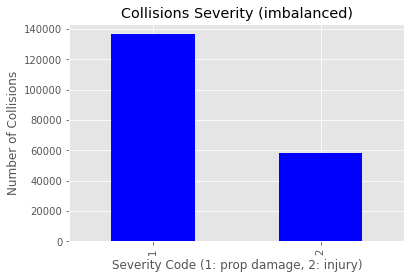

In [4]:
df.SEVERITYCODE.value_counts().plot(kind='bar', color='b')
plt.xlabel('Severity Code (1: prop damage, 2: injury)')
plt.ylabel('Number of Collisions')
plt.title('Collisions Severity (imbalanced)')

The metadata also reveals that there are several columns that contain unique identification keys for each collision, but which hold no value for a machine learning algorithm.  They serve the authority or organization that created them for cross-referencing purposes. Among those columns are `OBJECTID, INCKEY, COLDETKEY, REPORTNO, STATUS, INTKEY, EXCEPTRSNCODE, EXCEPTRSNDESC, SDOT_COLCODE, SDOT_COLDESC, SDOTCOLNUM, ST_COLCODE, ST_COLDESC, SEGLANEKEY,` and `CROSSWALKKEY`. As they hold no value for machine learning, they can also be dropped to narrow the feature set.

The remaining columns describe either the outcome of the collision or the conditions surrounding the accident. Among those that describe the outcome of the collision are `PERSONCOUNT, PEDCOUNT, PEDCYLCOUNT,` and `VEHCOUNT` (continuous) as well as `PEDROWNOTGRNT` and `HITPARKEDCAR` (categorical). They describe the number of various traffic participants and vehicles affected by the accident. Although continuous variables are generally a good source of information for supervised machine learning algorithm, the causality (cause-effect direction) is important. Especially, `PERSONCOUNT` or `VEHCOUNT` would make excellent target variables for prediction in a different type of supervised machine learning algorithm, namely regression. They are not truly independent of the collision or its severity but rather the result of it. Therefore, these columns are also be dropped.

In [5]:
# dropping unusable features
df = df.drop(columns=["SEVERITYCODE.1", "SEVERITYDESC", "COLLISIONTYPE",
                     "OBJECTID", "INCKEY", "COLDETKEY", "REPORTNO", "STATUS", "INTKEY", "EXCEPTRSNCODE", "EXCEPTRSNDESC", "SDOT_COLCODE", 
                      "SDOT_COLDESC", "SDOTCOLNUM", "ST_COLCODE", "ST_COLDESC", "SEGLANEKEY", "CROSSWALKKEY",
                     "PERSONCOUNT", "PEDCOUNT", "PEDCYLCOUNT", "VEHCOUNT", "PEDROWNOTGRNT", "HITPARKEDCAR" 
                     ])
df.head(2)

,SEVERITYCODE,X,Y,ADDRTYPE,LOCATION,INCDATE,INCDTTM,JUNCTIONTYPE,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,SPEEDING
0,2,-122.323148,47.703140,Intersection,5TH AVE NE AND NE 103RD ST,2013/03/27 00:00:00+00,3/27/2013 2:54:00 PM,At Intersection (intersection related),NaN,N,Overcast,Wet,Daylight,NaN
1,1,-122.347294,47.647172,Block,AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N,2006/12/20 00:00:00+00,12/20/2006 6:55:00 PM,Mid-Block (not related to intersection),NaN,0,Raining,Wet,Dark - Street Lights On,NaN


### 2.2 Feature Selection
Now, the rest of the features only describe the conditions before or surrounding the collision. The variables given as `X` and `Y` refer to longitude and latitude respectively (and are renamed as such), and they also make a written address in the variables `LOCATION` and `ADDRTYPE` redundant.

In [6]:
# renaming X and Y, dropping ADDRTYPE and LOCATION 
df = df.rename(columns={'X': 'LONGITUDE', 'Y': 'LATITUDE'})
df = df.drop(columns=["ADDRTYPE", "LOCATION"])
df.head(2)

,SEVERITYCODE,LONGITUDE,LATITUDE,INCDATE,INCDTTM,JUNCTIONTYPE,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,SPEEDING
0,2,-122.323148,47.703140,2013/03/27 00:00:00+00,3/27/2013 2:54:00 PM,At Intersection (intersection related),NaN,N,Overcast,Wet,Daylight,NaN
1,1,-122.347294,47.647172,2006/12/20 00:00:00+00,12/20/2006 6:55:00 PM,Mid-Block (not related to intersection),NaN,0,Raining,Wet,Dark - Street Lights On,NaN


The categorical variables `JUNCTIONTYPE, WEATHER, ROADCOND,` and `LIGHTCOND` describe the environmental factors and can be considered independent variables. They will be kept as features whose variation may explain the variation in collision severity. Similarly, the variation in the `INCDATE` and `INCDTTM` may help to explain the variation in the collision severity. Likewise, the variation in human behavior as observed by the columns `INATTENTIONIND, UNDERINFL,` and `SPEEDING` may help explain the variation in collision severity. As they precede the accident, they can also be considered independent variables and kept as features.

|   | Variable         | Description                 |
|--:|------------------|-----------------------------|
|1  | SEVERITYCODE     | code for the severity of the collision (1: prop damage, 2: injury) |
|2  | LONGITUDE        | longitude                   |
|3  | LATITUDE         | latitude                    |
|4  | JUNCTIONTYPE     | category of junction at which collision took place |
|5  | WEATHER          | description of the weather conditions during the collision |
|6  | ROADCOND         | condition of the road during the collision |
|7  | LIGHTCOND        | light conditions during the collision |
|8  | INCDATE          | date of the incident |
|9  | INDTTME          | date and time of the incident |
|10 | INATTENTIONIND   |whether or not collision was due to inattention |
|11 | UNDERINFL        |whether or not driver was involved under the influence of drugs or alcohol |
|12 | SPEEDING         |whether or not the speeding was a factor in the collision |


## 3. Data Preparation
The ultimate purpose of this chapter is to ready the pre-selected variable set for machine learning. Data preparation, also called pre-processing, includes steps such as exploratory data analysis (EDA) to confirm the selection of features, dealing with missing values, and converting variables into machine-legible data types. These steps will be applied to the environmental variables, human behavior variables and date-time variables. At the end, this chapter will also address the issue of label imbalance and employ a resampling method for balancing.

### 3.1 Environmental Variables
`LONGITUDE` and `LATITUDE` are continuous, numerical variables that together pinpoint the location of each recorded collision. Their minimum and maximum value map a square-shaped area of Seattle in which all collisions have been recorded. `LONGITUDE` and `LATITUDE` have 5,334 missing values. Common strategies of dealing with missing values in continuous variables are by replacing them either with their median or their mean. In this case, the median would just the point to the center of the square-shaped map of Seattle. But the mean would generally point to the area were collisions happen most frequently. `LONGITUDE` has a mean of approximately -122.33052 and `LATITUDE` has a mean of approximately 47.61954. Their missing values will be replaced with their mean values respectively.

In [7]:
print("Longitude has its upper border at", df["LONGITUDE"].max(), "and its lower border at", df["LONGITUDE"].min(), ".")
print("Latitude has its upper border at", df["LATITUDE"].max(), "and its lower border at", df["LATITUDE"].min(), ".")

Longitude has its upper border at -122.2389494 and its lower border at -122.41909109999999 .
Latitude has its upper border at 47.73414158 and its lower border at 47.49557292 .


In [8]:
print("Longitude has", df["LONGITUDE"].isna().sum(), "missing values.")
print("Latitude has", df["LATITUDE"].isna().sum(), "missing values.")

Longitude has 5334 missing values.
Latitude has 5334 missing values.


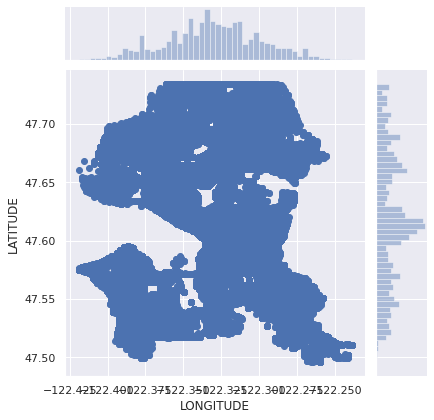

In [9]:
import seaborn as sns
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(10,10)})
sns.jointplot(x="LONGITUDE", y="LATITUDE", data=df)

In [10]:
print("Longitude has a mean of %.5f" % df["LONGITUDE"].mean(), ".")
print("Latitude has a mean o %.5f" % df["LATITUDE"].mean(), ".")

Longitude has a mean of -122.33052 .
Latitude has a mean o 47.61954 .


In [11]:
avg_LONGITUDE = df["LONGITUDE"].astype("float").mean()
df["LONGITUDE"].fillna(avg_LONGITUDE, inplace=True)
avg_LATITUDE = df["LATITUDE"].astype("float").mean()
df["LATITUDE"].fillna(avg_LATITUDE, inplace=True)
print(df["LONGITUDE"].value_counts())
print(df["LONGITUDE"].isna().sum())

-122.330518    5334
-122.332653     265
-122.344896     254
-122.328079     252
-122.344997     239
               ... 
-122.322768       1
-122.288680       1
-122.405699       1
-122.323578       1
-122.343898       1
Name: LONGITUDE, Length: 23564, dtype: int64
0


Next, `JUNCTIONTYPE, WEATHER, ROADCOND,` and `LIGHTCOND` are all categorical variables that describe the place and surrounding conditions of the accident. A common strategy of replacing missing values is to replace with the mode, the most frequent value.

For `JUNCTIONTYPE,` the mode is “Mid-Block (not related to intersection)” and it replaces 6,329 missing variables. “Unknown” values are dropped because their weight is insignificant. Afterwards, the different categories are converted into dummy variables for the machine learning algorithm, and the original variable `JUNCTIONTYPE` is dropped.

JUNCTIONTYPE                                       SEVERITYCODE
At Intersection (but not related to intersection)  1                1475
                                                   2                 623
At Intersection (intersection related)             1               35636
                                                   2               27174
Driveway Junction                                  1                7437
                                                   2                3234
Mid-Block (but intersection related)               1               15493
                                                   2                7297
Mid-Block (not related to intersection)            1               70396
                                                   2               19404
Ramp Junction                                      1                 112
                                                   2                  54
Unknown                                            1        

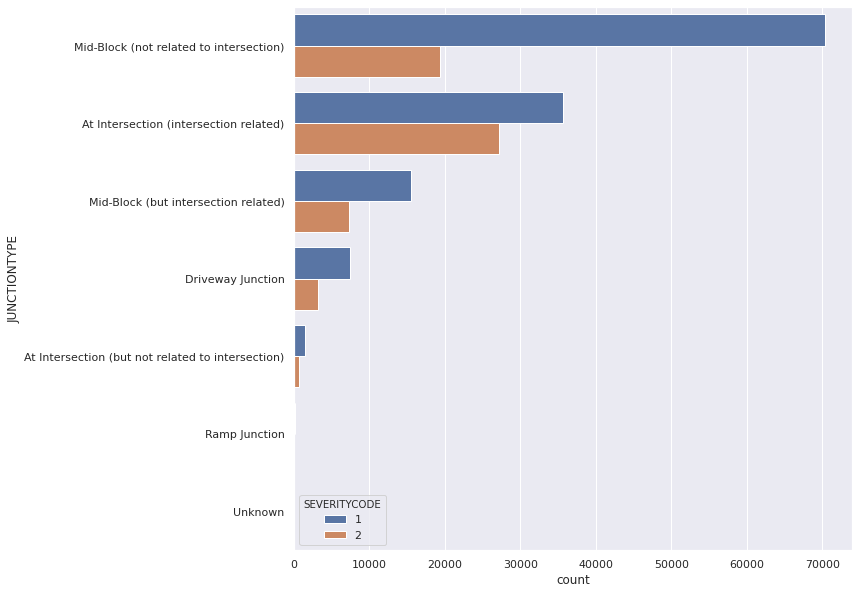

In [12]:
order = df["JUNCTIONTYPE"].value_counts().to_frame()
ax = sns.countplot(y="JUNCTIONTYPE", hue="SEVERITYCODE", order=order.index, data=df)
print(df.groupby(['JUNCTIONTYPE'])['SEVERITYCODE'].value_counts())
print(df["JUNCTIONTYPE"].isna().sum())

In [13]:
df['JUNCTIONTYPE'].replace(np.NaN, "Mid-Block (not related to intersection)", inplace=True)
df = pd.concat([df,pd.get_dummies(df['JUNCTIONTYPE'])], axis=1)
df.drop(['Unknown'], axis=1, inplace=True)
df.drop(["JUNCTIONTYPE"],axis=1, inplace=True) 
df.head()

,SEVERITYCODE,LONGITUDE,LATITUDE,INCDATE,INCDTTM,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,SPEEDING,At Intersection (but not related to intersection),At Intersection (intersection related),Driveway Junction,Mid-Block (but intersection related),Mid-Block (not related to intersection),Ramp Junction
0,2,-122.323148,47.703140,2013/03/27 00:00:00+00,3/27/2013 2:54:00 PM,NaN,N,Overcast,Wet,Daylight,NaN,0,1,0,0,0,0
1,1,-122.347294,47.647172,2006/12/20 00:00:00+00,12/20/2006 6:55:00 PM,NaN,0,Raining,Wet,Dark - Street Lights On,NaN,0,0,0,0,1,0
2,1,-122.334540,47.607871,2004/11/18 00:00:00+00,11/18/2004 10:20:00 AM,NaN,0,Overcast,Dry,Daylight,NaN,0,0,0,0,1,0
3,1,-122.334803,47.604803,2013/03/29 00:00:00+00,3/29/2013 9:26:00 AM,NaN,N,Clear,Dry,Daylight,NaN,0,0,0,0,1,0
4,2,-122.306426,47.545739,2004/01/28 00:00:00+00,1/28/2004 8:04:00 AM,NaN,0,Raining,Wet,Daylight,NaN,0,1,0,0,0,0


For `WEATHER,` the mode “Clear” will replace all 5,081 missing values. Since there is no indication what “Other” weather is, it is merged with the category “Unknown”. “Unknown” is renamed as “Unknown Weather” to distinguish it from the variable “Unknown Roadcond” to be created in the next step. Additionally, as “Partly Cloudy” is insignificant to it is merged with “Overcast”. `WEATHER` is also dropped in place for its dummies.

SEVERITYCODE  WEATHER                 
1             Clear                       75295
              Raining                     21969
              Overcast                    18969
              Unknown                     14275
              Snowing                       736
              Other                         716
              Fog/Smog/Smoke                382
              Sleet/Hail/Freezing Rain       85
              Blowing Sand/Dirt              41
              Severe Crosswind               18
              Partly Cloudy                   2
2             Clear                       35840
              Raining                     11176
              Overcast                     8745
              Unknown                       816
              Fog/Smog/Smoke                187
              Snowing                       171
              Other                         116
              Sleet/Hail/Freezing Rain       28
              Blowing Sand/Dirt              15
 

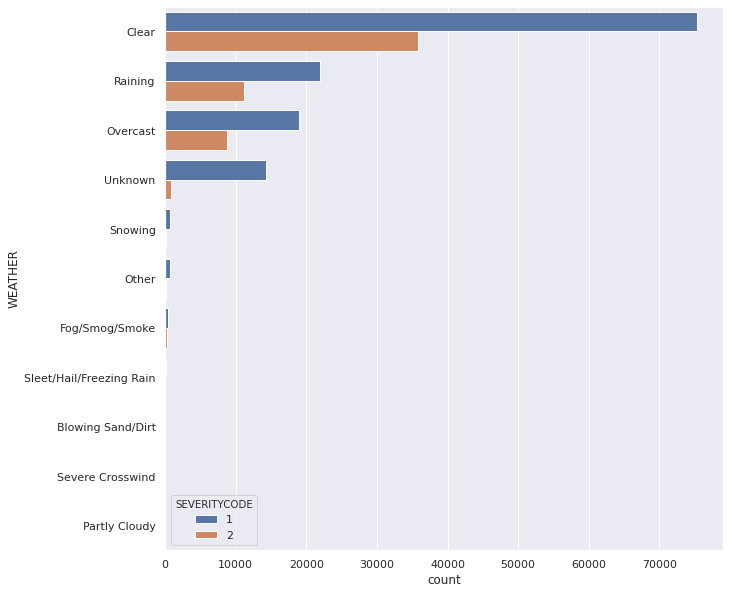

In [14]:
order = df["WEATHER"].value_counts().to_frame()
ax = sns.countplot(y="WEATHER", hue="SEVERITYCODE", order=order.index, data=df)
print(df.groupby(['SEVERITYCODE'])['WEATHER'].value_counts())
print(df["WEATHER"].isna().sum())

In [15]:
df["WEATHER"].replace(np.NaN, "Clear", inplace=True)
df["WEATHER"].replace("Other", "Unknown", inplace=True)
df["WEATHER"].replace("Unknown", "Unknown Weather", inplace=True)
df["WEATHER"].replace("Partly Cloudy", "Overcast", inplace=True)
df = pd.concat([df,pd.get_dummies(df['WEATHER'])], axis=1)
df.drop(["WEATHER"],axis=1, inplace=True)
df.head()

,SEVERITYCODE,LONGITUDE,LATITUDE,INCDATE,INCDTTM,INATTENTIONIND,UNDERINFL,ROADCOND,LIGHTCOND,SPEEDING,...,Ramp Junction,Blowing Sand/Dirt,Clear,Fog/Smog/Smoke,Overcast,Raining,Severe Crosswind,Sleet/Hail/Freezing Rain,Snowing,Unknown Weather
0,2,-122.323148,47.703140,2013/03/27 00:00:00+00,3/27/2013 2:54:00 PM,NaN,N,Wet,Daylight,NaN,...,0,0,0,0,1,0,0,0,0,0
1,1,-122.347294,47.647172,2006/12/20 00:00:00+00,12/20/2006 6:55:00 PM,NaN,0,Wet,Dark - Street Lights On,NaN,...,0,0,0,0,0,1,0,0,0,0
2,1,-122.334540,47.607871,2004/11/18 00:00:00+00,11/18/2004 10:20:00 AM,NaN,0,Dry,Daylight,NaN,...,0,0,0,0,1,0,0,0,0,0
3,1,-122.334803,47.604803,2013/03/29 00:00:00+00,3/29/2013 9:26:00 AM,NaN,N,Dry,Daylight,NaN,...,0,0,1,0,0,0,0,0,0,0
4,2,-122.306426,47.545739,2004/01/28 00:00:00+00,1/28/2004 8:04:00 AM,NaN,0,Wet,Daylight,NaN,...,0,0,0,0,0,1,0,0,0,0


“Dry” is the mode of `ROADCOND` and will replace all the 5,012 missing values. Again, “Other” is merged with “Unknown”. Moreover, “Standing Water” is added to “Wet” and “Snow/Slush” is added to “Ice” as the former in those pairs are very similar to the latter. “Unknown” is renamed “Unknown Roadcond”. It should not be dropped as it is the third largest category.

SEVERITYCODE  ROADCOND      
1             Dry               84446
              Wet               31719
              Unknown           14329
              Ice                 936
              Snow/Slush          837
              Other                89
              Standing Water       85
              Sand/Mud/Dirt        52
              Oil                  40
2             Dry               40064
              Wet               15755
              Unknown             749
              Ice                 273
              Snow/Slush          167
              Other                43
              Standing Water       30
              Oil                  24
              Sand/Mud/Dirt        23
Name: ROADCOND, dtype: int64
5012


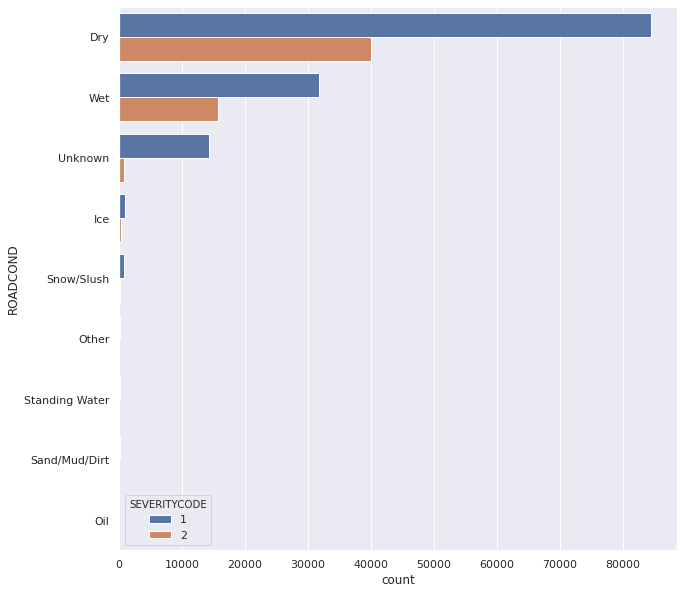

In [16]:
order = df["ROADCOND"].value_counts().to_frame()
ax = sns.countplot(y="ROADCOND", hue="SEVERITYCODE", order=order.index, data=df)
print(df.groupby(['SEVERITYCODE'])['ROADCOND'].value_counts())
print(df["ROADCOND"].isna().sum())

In [17]:
df["ROADCOND"].replace(np.NaN, "Dry", inplace=True)
df["ROADCOND"].replace("Other", "Unknown", inplace=True)
df["ROADCOND"].replace("Unknown", "Unknown Roadcond", inplace=True)
df["ROADCOND"].replace("Standing Water", "Wet", inplace=True)
df["ROADCOND"].replace("Snow/Slush", "Ice", inplace=True)
df = pd.concat([df,pd.get_dummies(df['ROADCOND'])], axis=1)
df.drop(["ROADCOND"],axis=1, inplace=True)
df.head()

,SEVERITYCODE,LONGITUDE,LATITUDE,INCDATE,INCDTTM,INATTENTIONIND,UNDERINFL,LIGHTCOND,SPEEDING,At Intersection (but not related to intersection),...,Severe Crosswind,Sleet/Hail/Freezing Rain,Snowing,Unknown Weather,Dry,Ice,Oil,Sand/Mud/Dirt,Unknown Roadcond,Wet
0,2,-122.323148,47.703140,2013/03/27 00:00:00+00,3/27/2013 2:54:00 PM,NaN,N,Daylight,NaN,0,...,0,0,0,0,0,0,0,0,0,1
1,1,-122.347294,47.647172,2006/12/20 00:00:00+00,12/20/2006 6:55:00 PM,NaN,0,Dark - Street Lights On,NaN,0,...,0,0,0,0,0,0,0,0,0,1
2,1,-122.334540,47.607871,2004/11/18 00:00:00+00,11/18/2004 10:20:00 AM,NaN,0,Daylight,NaN,0,...,0,0,0,0,1,0,0,0,0,0
3,1,-122.334803,47.604803,2013/03/29 00:00:00+00,3/29/2013 9:26:00 AM,NaN,N,Daylight,NaN,0,...,0,0,0,0,1,0,0,0,0,0
4,2,-122.306426,47.545739,2004/01/28 00:00:00+00,1/28/2004 8:04:00 AM,NaN,0,Daylight,NaN,0,...,0,0,0,0,0,0,0,0,0,1


Lastly, `LIGHTCOND` is encoded as a single dummy, where 0 stands for “Daylight” and 1 for all other conditions. 5,170 missing values are also replaced with “Daylight,” the most frequent category.

SEVERITYCODE  LIGHTCOND               
1             Daylight                    77593
              Dark - Street Lights On     34032
              Unknown                     12868
              Dusk                         3958
              Dawn                         1678
              Dark - No Street Lights      1203
              Dark - Street Lights Off      883
              Other                         183
              Dark - Unknown Lighting         7
2             Daylight                    38544
              Dark - Street Lights On     14475
              Dusk                         1944
              Dawn                          824
              Unknown                       605
              Dark - No Street Lights       334
              Dark - Street Lights Off      316
              Other                          52
              Dark - Unknown Lighting         4
Name: LIGHTCOND, dtype: int64
5170


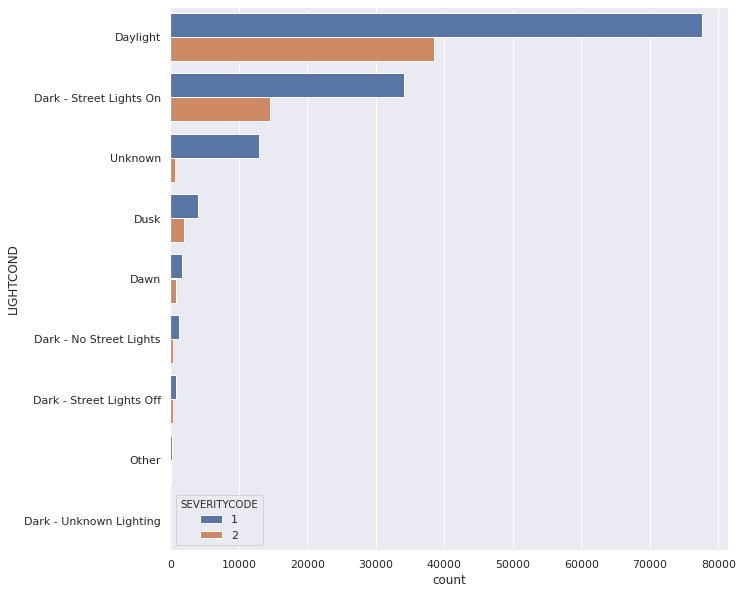

In [18]:
order = df["LIGHTCOND"].value_counts().to_frame()
ax = sns.countplot(y="LIGHTCOND", hue="SEVERITYCODE", order=order.index, data=df)
print(df.groupby(['SEVERITYCODE'])['LIGHTCOND'].value_counts())
print(df["LIGHTCOND"].isna().sum())

In [19]:
df["LIGHTCOND"].replace(np.NaN, "Daylight", inplace=True)
df["LIGHTCOND"].value_counts()

Daylight                    121307
Dark - Street Lights On      48507
Unknown                      13473
Dusk                          5902
Dawn                          2502
Dark - No Street Lights       1537
Dark - Street Lights Off      1199
Other                          235
Dark - Unknown Lighting         11
Name: LIGHTCOND, dtype: int64

In [20]:
encoding_LIGHTCOND = {"LIGHTCOND": 
                            {"Daylight": 0,
                             "Unknown": 1,
                             "Other": 1,
                             "Dark - Street Lights On": 1,
                             "Dusk": 1,
                             "Dawn": 1,
                             "Dark - No Street Lights": 1,
                             "Dark - Street Lights Off": 1,
                             "Dark - Unknown Lighting": 1,
                              }}
df.replace(encoding_LIGHTCOND, inplace=True)
df['LIGHTCOND'].value_counts()

0    121307
1     73366
Name: LIGHTCOND, dtype: int64

### 3.2 Human Behavior Variables
The variables `INATTENTIONIND, UNDERINFL,` and `SPEEDING` describe human behaviors that are assumed to increase the chances of an accident.

For `INATTENTIONIND,` 29,805 observations are given as “Y”, which means the missing 164,868 will assumed to be “N” and filled in accordingly. They are encoded as 1 and 0 respectively. It is very intuitive as this suggests that most accidents happen even when people are not paying attention to traffic. Since attention span may be highly depended on the time of the day, the variable `INCDTTM` is dropped.``

In [21]:
print(df["INATTENTIONIND"].value_counts())
print(df["INATTENTIONIND"].isna().sum())

Y    29805
Name: INATTENTIONIND, dtype: int64
164868


In [22]:
df['INATTENTIONIND'].replace(np.NaN, "N", inplace=True)
encoding_INATTENTIONIND = {"INATTENTIONIND": 
                            {"Y": 1,
                             "N": 0,
                              }}
df.replace(encoding_INATTENTIONIND, inplace=True)
df['INATTENTIONIND'].value_counts()
df.drop(["INCDTTM"],axis=1, inplace=True)

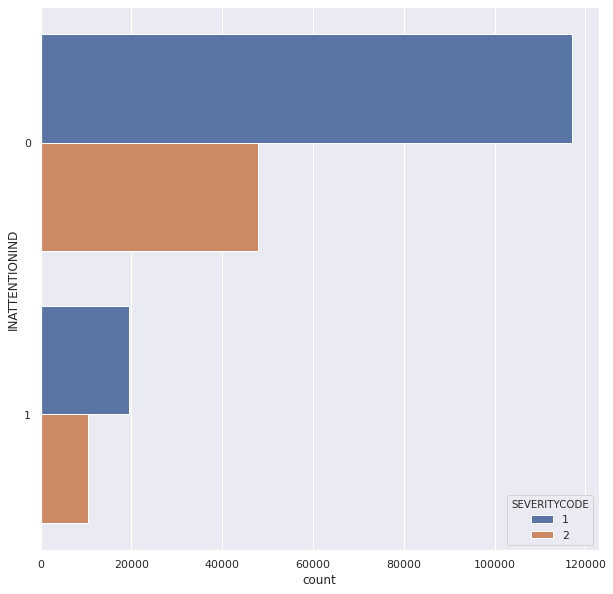

In [23]:
ax = sns.countplot(y="INATTENTIONIND", hue="SEVERITYCODE", data=df)

The column `UNDERINFL` has four values (“Y”, “N”, 1, and 0). Since no further indication is given in the metadata, it is assumed that “Y” equates to 1 and “N” equates to 0. Missing values are placed with 0. Here a highly counter-intuitive picture emerges, most accidents happen when people are not under the influence of drugs or alcohol.

In [24]:
print(df.groupby(['SEVERITYCODE'])['UNDERINFL'].value_counts())
print(df["UNDERINFL"].isna().sum())

SEVERITYCODE  UNDERINFL
1             N            69378
              0            57693
              Y             3187
              1             2372
2             N            30896
              0            22701
              Y             1939
              1             1623
Name: UNDERINFL, dtype: int64
4884


In [25]:
df["UNDERINFL"].fillna(0, inplace=True)
encoding_UNDERINFL = {"UNDERINFL": 
                            {"1": 1,
                             "0": 0,
                             "Y": 1,
                             "N": 0
                              }}
df.replace(encoding_UNDERINFL, inplace=True)
print(df["UNDERINFL"].value_counts())
print(df["UNDERINFL"].dtypes)

0    185552
1      9121
Name: UNDERINFL, dtype: int64
int64


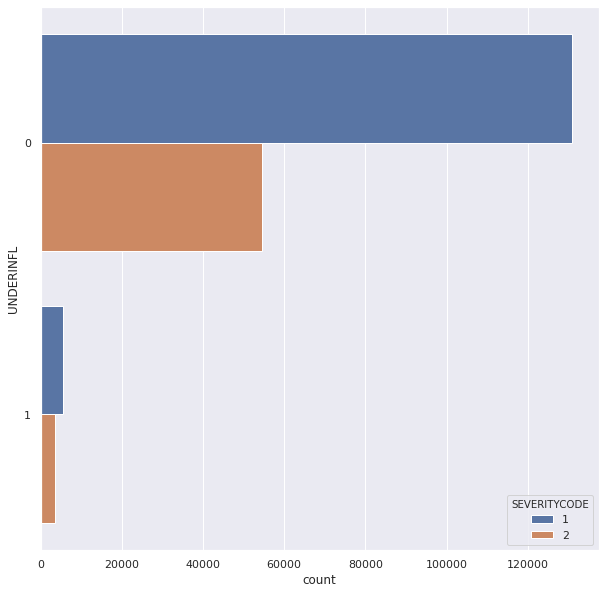

In [26]:
ax = sns.countplot(y="UNDERINFL", hue="SEVERITYCODE", data=df)

For `SPEEDING,` 9,333 observations are given as “Y”, which means the missing 185,340 will assumed to be “N”. They are also encoded as 1 and 0. Counter-intuitively, most collisions occurred without speeding.

In [27]:
print(df['SPEEDING'].value_counts())
print(df["SPEEDING"].isna().sum())

Y    9333
Name: SPEEDING, dtype: int64
185340


In [28]:
df["SPEEDING"].replace(np.NaN, "N", inplace=True)
encoding_SPEEDING = {"SPEEDING": 
                            {"Y": 1,
                             "N": 0,
                              }}
df.replace(encoding_SPEEDING, inplace=True)
df['SPEEDING'].value_counts()

0    185340
1      9333
Name: SPEEDING, dtype: int64

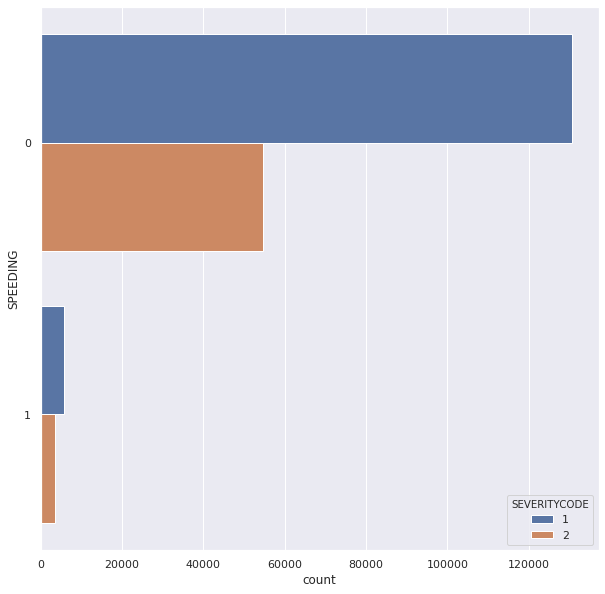

In [29]:
ax = sns.countplot(y="SPEEDING", hue="SEVERITYCODE", data=df)

### 3.3 Date-Time Variables
The assumption about the date of the collision is closely related to those about the human behavior variables, i.e. during certain days of the week, people are less attentive, for instance, due to exhaustion from work. A cursory analysis confirms that most collisions happen on Fridays while the fewest happen on Sunday . The variable `INCDATE` is converted into dummy variable, where 1 stands for weekend and 0 weekdays.

In [30]:
df["INCDATE"] = pd.to_datetime(df["INCDATE"])
df["INCDATE"].head()

0   2013-03-27 00:00:00+00:00
1   2006-12-20 00:00:00+00:00
2   2004-11-18 00:00:00+00:00
3   2013-03-29 00:00:00+00:00
4   2004-01-28 00:00:00+00:00
Name: INCDATE, dtype: datetime64[ns, UTC]

In [31]:
df["DAYOFWEEK"] = df["INCDATE"].dt.dayofweek
df["DAYOFWEEK"].value_counts()

4    32333
3    29324
2    28778
1    28556
5    27389
0    26338
6    21955
Name: DAYOFWEEK, dtype: int64

In [32]:
df['WEEKEND'] = df['DAYOFWEEK'].apply(lambda x: 1 if (x>4)  else 0)
df["WEEKEND"].value_counts()

0    145329
1     49344
Name: WEEKEND, dtype: int64

WEEKEND  SEVERITYCODE
0        1               101291
         2                44038
1        1                35194
         2                14150
Name: SEVERITYCODE, dtype: int64


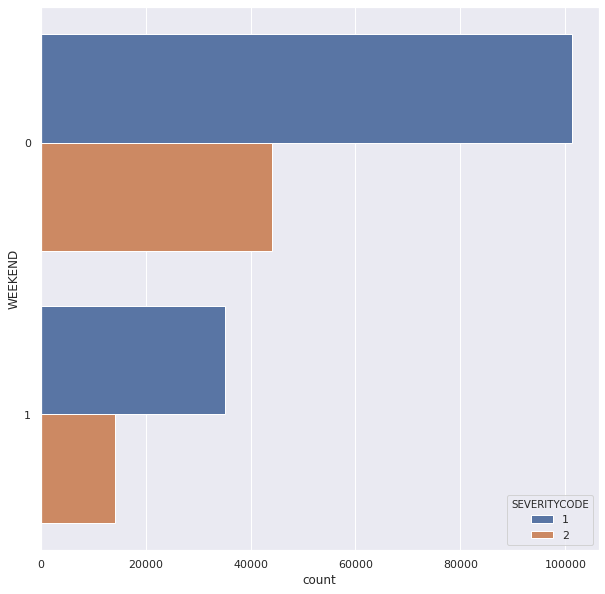

In [33]:
import seaborn as sns
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(10,10)})
ax_weekend = sns.countplot(y="WEEKEND", hue="SEVERITYCODE", data=df)
print(df.groupby(["WEEKEND"])["SEVERITYCODE"].value_counts())

DAYOFWEEK  SEVERITYCODE
0          1               18365
           2                7973
1          1               19825
           2                8731
2          1               20021
           2                8757
3          1               20306
           2                9018
4          1               22774
           2                9559
5          1               19342
           2                8047
6          1               15852
           2                6103
Name: SEVERITYCODE, dtype: int64


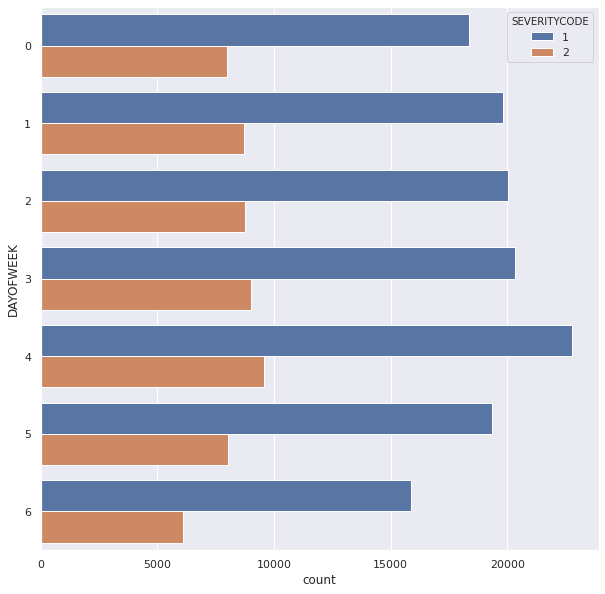

In [34]:
ax_dayofweek = sns.countplot(y="DAYOFWEEK", hue="SEVERITYCODE", data=df)
print(df.groupby(["DAYOFWEEK"])["SEVERITYCODE"].value_counts())

In [35]:
df.drop(["INCDATE"],axis=1, inplace=True)
df.drop(["DAYOFWEEK"],axis=1, inplace=True)

__Control Check for Missing Values__

In [36]:
df.isna().sum()

SEVERITYCODE                                         0
LONGITUDE                                            0
LATITUDE                                             0
INATTENTIONIND                                       0
UNDERINFL                                            0
LIGHTCOND                                            0
SPEEDING                                             0
At Intersection (but not related to intersection)    0
At Intersection (intersection related)               0
Driveway Junction                                    0
Mid-Block (but intersection related)                 0
Mid-Block (not related to intersection)              0
Ramp Junction                                        0
Blowing Sand/Dirt                                    0
Clear                                                0
Fog/Smog/Smoke                                       0
Overcast                                             0
Raining                                              0
Severe Cro

### 3.4 Balancing the Dataset
In this dataset, 58,188 injury collision (class 2) and 136,485 property-damage-only collision (class 1) are recorded. Many real-world classification problems have an imbalanced class distribution such as fraud detection, churn prediction, or extreme event prediction. Slight imbalances between classes are considered to have ratio around 4:6, while severe imbalances are considered to have a ratio of 1:100 or more. Thus, the Collision Dataset with an approximate ratio of 58:137 has a severe imbalance. The abundant class, in this case property damage collision (class), is called majority class, whereas the one with fewer samples is called minority class. By definition, a minority class is difficult to predict because of its few examples. This means it is more challenging for a machine learning model to learn the characteristics of examples from this class and to distinguish it from the majority class. In fact, most classification algorithms are designed and demonstrated on problems that assume an equal distribution of classes.

The two common strategies of rectifying imbalanced classes in machine learning are random over-sampling (ROS) and random under-sampling (RUS). ROS is the process of supplementing the dataset with multiple, randomly chosen copies of cases from the minority class, until the number of samples match the majority class. RUS randomly deletes samples from the majority class until the number of samples matches the minority class. Both methods come with advantages and disadvantages. While ROS may inflate or exaggerate underlying patterns in the minority class, RUS may potentially discard important samples of majority class und distort its underlying patterns. A rule of thumb is to use ROS when the given dataset is small and RUS when the given dataset is large. As the Collision Dataset is sufficiently large, this report employs the method random under-sampling to rectify the imbalance and thereby reducing class 1 collisions to 58,188 samples.

In [37]:
conda install -c conda-forge imbalanced-learn # packages for balance techniques

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [38]:
df.columns

Index(['SEVERITYCODE', 'LONGITUDE', 'LATITUDE', 'INATTENTIONIND', 'UNDERINFL',
       'LIGHTCOND', 'SPEEDING',
       'At Intersection (but not related to intersection)',
       'At Intersection (intersection related)', 'Driveway Junction',
       'Mid-Block (but intersection related)',
       'Mid-Block (not related to intersection)', 'Ramp Junction',
       'Blowing Sand/Dirt', 'Clear', 'Fog/Smog/Smoke', 'Overcast', 'Raining',
       'Severe Crosswind', 'Sleet/Hail/Freezing Rain', 'Snowing',
       'Unknown Weather', 'Dry', 'Ice', 'Oil', 'Sand/Mud/Dirt',
       'Unknown Roadcond', 'Wet', 'WEEKEND'],
      dtype='object')

In [39]:
x = df[['LONGITUDE', 'LATITUDE', 'INATTENTIONIND', 'UNDERINFL',
       'LIGHTCOND', 'SPEEDING',
       'At Intersection (but not related to intersection)',
       'At Intersection (intersection related)', 'Driveway Junction',
       'Mid-Block (but intersection related)',
       'Mid-Block (not related to intersection)', 'Ramp Junction',
       'Blowing Sand/Dirt', 'Clear', 'Fog/Smog/Smoke', 'Overcast', 'Raining',
       'Severe Crosswind', 'Sleet/Hail/Freezing Rain', 'Snowing',
       'Unknown Weather', 'Dry', 'Ice', 'Oil', 'Sand/Mud/Dirt',
       'Unknown Roadcond', 'Wet', 'WEEKEND']] 
y = df['SEVERITYCODE']
from imblearn.under_sampling import RandomUnderSampler
RUS = RandomUnderSampler(random_state=0)
x_resampled, y_resampled = RUS.fit_resample(x, y)
print(y_resampled.value_counts())
print(x_resampled[0:5])

2    58188
1    58188
Name: SEVERITYCODE, dtype: int64
    LONGITUDE   LATITUDE  INATTENTIONIND  UNDERINFL  LIGHTCOND  SPEEDING  \
0 -122.360474  47.525591               0          1          1         0   
1 -122.309524  47.691686               0          0          0         0   
2 -122.383230  47.680637               0          0          1         0   
3 -122.378418  47.690604               0          0          1         0   
4 -122.330518  47.619543               0          0          1         0   

   At Intersection (but not related to intersection)  \
0                                                  0   
1                                                  0   
2                                                  0   
3                                                  0   
4                                                  0   

   At Intersection (intersection related)  Driveway Junction  \
0                                       0                  0   
1                      